# **Klasifikasi Gambar Hewan (6 Hewan)**

## Import Library

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"addull","key":"f0af05aa033ecda18600b92550528267"}'}

In [ ]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

In [ ]:
# Path ke direktori dataset
base_path = "raw-img"

# Mapping nama folder Italia ke Indonesia
rename_map = {
    "cane": "anjing",
    "cavallo": "kuda",
    "elefante": "gajah",
    "farfalla": "kupu-kupu",
    "gallina": "ayam",
    "gatto": "kucing",
    "mucca": "sapi",
    "pecora": "domba",
    "ragno": "laba-laba",
    "scoiattolo": "tupai"
}

# Ganti nama folder
for italia, indonesia in rename_map.items():
    old_path = os.path.join(base_path, italia)
    new_path = os.path.join(base_path, indonesia)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"✅ Berhasil mengganti: {old_path} → {new_path}")
    else:
        print(f"❌ Folder tidak ditemukan: {old_path}")

✅ Berhasil mengganti: raw-img/cane → raw-img/anjing
✅ Berhasil mengganti: raw-img/cavallo → raw-img/kuda
✅ Berhasil mengganti: raw-img/elefante → raw-img/gajah
✅ Berhasil mengganti: raw-img/farfalla → raw-img/kupu-kupu
✅ Berhasil mengganti: raw-img/gallina → raw-img/ayam
✅ Berhasil mengganti: raw-img/gatto → raw-img/kucing
✅ Berhasil mengganti: raw-img/mucca → raw-img/sapi
✅ Berhasil mengganti: raw-img/pecora → raw-img/domba
✅ Berhasil mengganti: raw-img/ragno → raw-img/laba-laba
✅ Berhasil mengganti: raw-img/scoiattolo → raw-img/tupai


In [ ]:
!rm -r /content/raw-img/gajah

In [ ]:
!rm -r /content/raw-img/domba

In [ ]:
!rm -r /content/raw-img/kuda

In [ ]:
!rm -r /content/raw-img/laba-laba

In [ ]:
!cp -r /content/raw-img /content/drive/MyDrive/proyek_BPML-6

##Plot Gambar Sample dan Distribusi

In [ ]:
raw_img_path = "/content/raw-img"

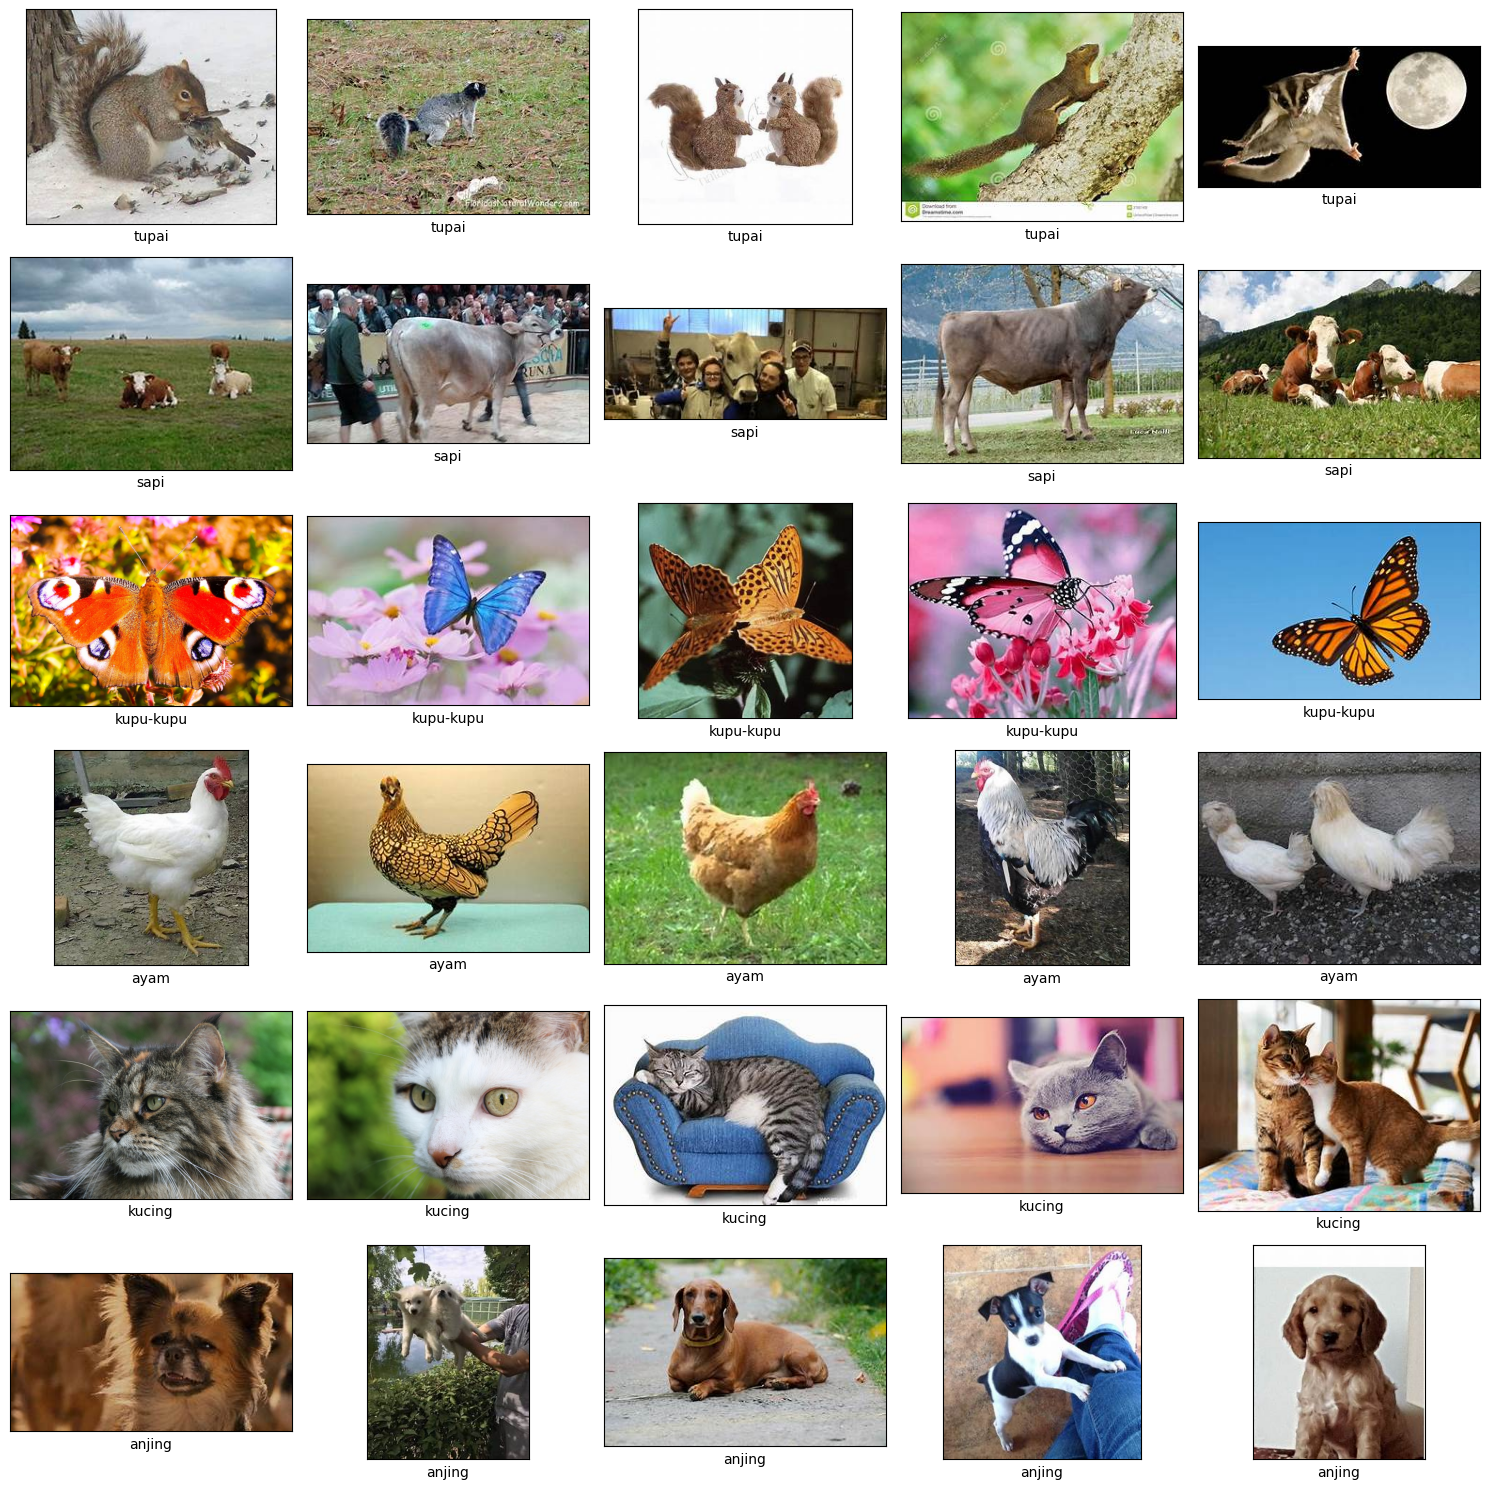

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_image = {}

# Tentukan path sumber train
path = raw_img_path
path_sub = os.path.join(path)
for i in os.listdir(path_sub):
    animal_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah dari setiap kelas.
path_sub = "raw-img/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

In [ ]:
import os

def count_images(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print(f"\n📁 Jumlah gambar per kelas di folder:")
counts = count_images(raw_img_path)
for class_name, count in counts.items():
        print(f"  {class_name:<20}: {count} gambar")
        total = sum(counts.values())
print(f"\nTotal: {total} gambar")



📁 Jumlah gambar per kelas di folder:
  tupai               : 1862 gambar
  sapi                : 1866 gambar
  kupu-kupu           : 2112 gambar
  ayam                : 3098 gambar
  kucing              : 1668 gambar
  anjing              : 4863 gambar

Total: 15469 gambar


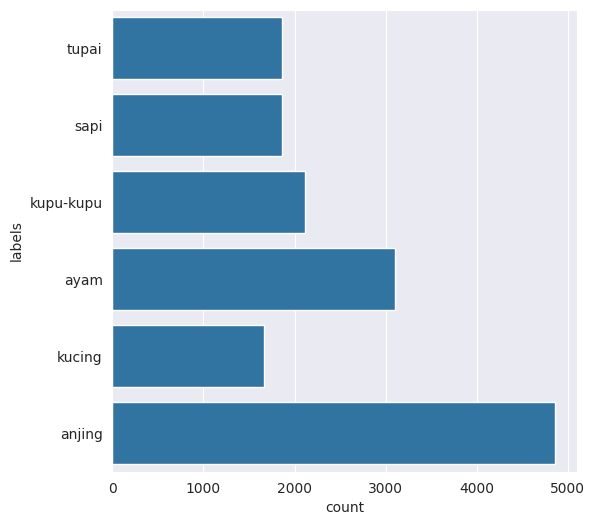

In [ ]:
# Define source path
animals_path = raw_img_path

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(animals_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Augmentasi Gambar

In [ ]:
import os
import random
import uuid
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm

# --- Konfigurasi Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Loop setiap folder kelas ---
for class_folder in os.listdir(raw_img_path):
    class_path = os.path.join(raw_img_path, class_folder)
    if not os.path.isdir(class_path):
        continue

    # --- Atur jumlah augmentasi per kelas ---
    if class_folder == 'kupu-kupu':
        images_to_generate_per_class = 900
    elif class_folder in ['tupai', 'sapi']:
        images_to_generate_per_class = 1200
    elif class_folder == 'kucing':
        images_to_generate_per_class = 1400
    else:
        images_to_generate_per_class = 0

    print(f"\n🔄 Augmentasi untuk kelas: {class_folder}...")

    images = [os.path.join(class_path, f) for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    total_aug = 0
    pbar = tqdm(total=images_to_generate_per_class)

    while total_aug < images_to_generate_per_class:
        image_path = random.choice(images)
        try:
            img = load_img(image_path)  # format PIL
            x = img_to_array(img)  # convert to numpy array
            x = np.expand_dims(x, axis=0)  # add batch dimension

            # Generator augmentasi
            aug_iter = datagen.flow(x, batch_size=1)

            # Ambil satu gambar hasil augmentasi
            aug_image = next(aug_iter)[0].astype('uint8')

            # Simpan hasilnya
            save_path = os.path.join(class_path, f"aug_{uuid.uuid4().hex}.jpg")
            saved = cv2.imwrite(save_path, aug_image)

            if saved:
                total_aug += 1
                pbar.update(1)
            else:
                print(f"❌ Gagal menyimpan: {save_path}")

        except Exception as e:
            print(f"⚠️ Gagal memproses {image_path}: {e}")

    pbar.close()
    print(f"✅ Selesai augmentasi untuk kelas: {class_folder}\n")



🔄 Augmentasi untuk kelas: tupai...


100%|██████████| 1200/1200 [00:18<00:00, 65.77it/s]


✅ Selesai augmentasi untuk kelas: tupai


🔄 Augmentasi untuk kelas: sapi...


100%|██████████| 1200/1200 [00:18<00:00, 66.59it/s]


✅ Selesai augmentasi untuk kelas: sapi


🔄 Augmentasi untuk kelas: kupu-kupu...


100%|██████████| 900/900 [00:23<00:00, 38.81it/s]


✅ Selesai augmentasi untuk kelas: kupu-kupu


🔄 Augmentasi untuk kelas: ayam...


0it [00:00, ?it/s]


✅ Selesai augmentasi untuk kelas: ayam


🔄 Augmentasi untuk kelas: kucing...


100%|██████████| 1400/1400 [03:09<00:00,  7.39it/s]


✅ Selesai augmentasi untuk kelas: kucing


🔄 Augmentasi untuk kelas: anjing...


0it [00:00, ?it/s]

✅ Selesai augmentasi untuk kelas: anjing



In [ ]:
import os
import random

# === Folder yang ingin dikurangi ===
folder_hapus = raw_img_path+"/anjing"
jumlah_hapus = 1800

print(f"\n📁 Memproses folder: {folder_hapus}")

# Ambil semua file gambar
gambar = [f for f in os.listdir(folder_hapus) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Pilih gambar secara acak dan hapus
gambar_terpilih = random.sample(gambar, jumlah_hapus)
for nama_file in gambar_terpilih:
    path_file = os.path.join(folder_hapus, nama_file)
    try:
        os.remove(path_file)
        print(f"🗑️ Dihapus: {nama_file}")
    except Exception as e:
        print(f"⚠️ Gagal menghapus {nama_file}: {e}")



📁 Memproses folder: /content/raw-img/anjing
🗑️ Dihapus: OIP-TjdgekdgCPB7QGBGmF7R-wHaFY.jpeg
🗑️ Dihapus: OIP-Ip7xzuHRYuoV_mPW8qX_FwHaE7.jpeg
🗑️ Dihapus: OIP-c-gsCeZeEVMDDiz-ZfH1lQHaFj.jpeg
🗑️ Dihapus: OIP-VkiRr2o_2S1ZN4fy9aDH3gDYEg.jpeg
🗑️ Dihapus: OIP-Doy1fnsUhX32aqqxPhNirAHaEK.jpeg
🗑️ Dihapus: OIP-iwmccqImY8oUS1AwBrwctQHaFj.jpeg
🗑️ Dihapus: OIP-6dq-7yOIcdeQ5MbZWrl2iwHaFj.jpeg
🗑️ Dihapus: OIP-wQaFxWPKGnimzXGnZ6iVZQHaE7.jpeg
🗑️ Dihapus: OIP-G1EICWUoq1gwhkzCNHWj3QHaHa.jpeg
🗑️ Dihapus: OIP-kcQ0v1ycm0HGrItbMbBOZQAAAA.jpeg
🗑️ Dihapus: OIP-GQrxAMWPyUK5aIFt65RD7AHaFm.jpeg
🗑️ Dihapus: OIP-BKE_rLvv5pU_zIAaszmWxAHaGl.jpeg
🗑️ Dihapus: OIP-fva2NLIFwSbsvTEiPJtHuwHaFH.jpeg
🗑️ Dihapus: OIP-s4w4pD-1WDRJ6RtHDO7yqQHaFW.jpeg
🗑️ Dihapus: OIP-Uejj_lc_lZmGYJKfoQgtXQAAAA.jpeg
🗑️ Dihapus: OIP-AEG6uznzZ0O36UESXv3NawHaFj.jpeg
🗑️ Dihapus: OIP-mSLwG-QN-SQhKnOJAVuFngHaEo.jpeg
🗑️ Dihapus: OIP-3i-LDm_yo0nvdQigyjbNvQHaE7.jpeg
🗑️ Dihapus: OIP-mB7C-lv4Gu3sgEfWBR_w4AHaEc.jpeg
🗑️ Dihapus: OIP-UectaHAaCVsbtf9HfkrpdQHaFj.


📁 Jumlah gambar per kelas di folder:
  tupai               : 3062 gambar
  sapi                : 3066 gambar
  kupu-kupu           : 3012 gambar
  ayam                : 3098 gambar
  kucing              : 3068 gambar
  anjing              : 3063 gambar

Total: 18369 gambar


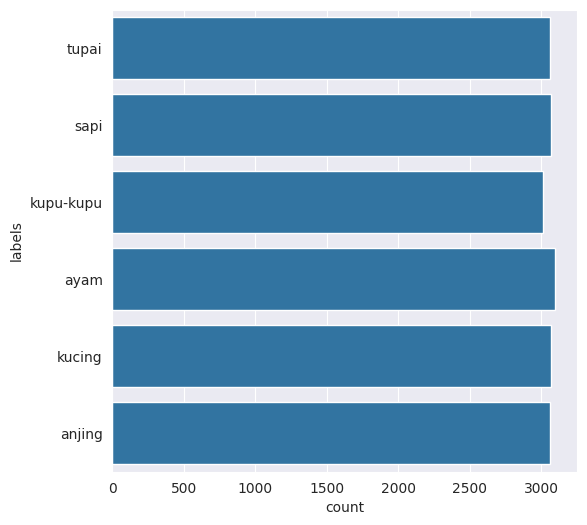

In [ ]:
import os

def count_images(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print(f"\n📁 Jumlah gambar per kelas di folder:")
counts = count_images(raw_img_path)
for class_name, count in counts.items():
        print(f"  {class_name:<20}: {count} gambar")
        total = sum(counts.values())
print(f"\nTotal: {total} gambar")

# Define source path
animals_path = raw_img_path

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(animals_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Data Splitting

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= raw_img_path

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
anjing       3063
ayam         3098
kucing       3068
kupu-kupu    3012
sapi         3066
tupai        3062
dtype: int64

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train+val dan test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=300)

# Split dataset train+val menjadi train dan val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=300) # 0.1765 agar val = 15% dari total (karena 0.85 * 0.1765 ≈ 0.15)

# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})

# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))
print('val size', len(df_val))

train size 12857
test size 2756
val size 2756


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   anjing        465
       ayam          431
       kucing        496
       kupu-kupu     480
       sapi          448
       tupai         436
train  anjing       2161
       ayam         2175
       kucing       2115
       kupu-kupu    2090
       sapi         2135
       tupai        2181
val    anjing        437
       ayam          492
       kucing        457
       kupu-kupu     442
       sapi          483
       tupai         445
dtype: int64 


                                                    path     labels    set
5491   /content/raw-img/sapi/OIP-gHyrIXIIKIRgg0st701G...       sapi  train
13401  /content/raw-img/kucing/ea37b80f2ff6083ed1584d...     kucing   test
950    /content/raw-img/kupu-kupu/eb30b40b28f7083ed15...  kupu-kupu  train
5869   /content/raw-img/kupu-kupu/OIP-7csbSDZu-smxbz6...  kupu-kupu  train
15975  /content/raw-img/anjing/OIP-6iPHVFKO_x2SLHOIL2...     anjing    val


## Menyimpan Dataset hasil splitting

In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "content/raw-img"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/dataset-final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
!cp -r /content/dataset-final/ /content/drive/MyDrive/proyek_BPML-6/dataset-final

##Load Dataset dari back-up

In [ ]:
!cp -r /content/drive/MyDrive/proyek_BPML-6/dataset-final /content/dataset-final/

In [ ]:
dataset_final_path = "/content/dataset-final"
train_path = dataset_final_path + "/train"
test_path = dataset_final_path + "/test"
val_path = dataset_final_path + "/val"

In [ ]:
from PIL import Image
import os

# Daftar direktori yang ingin diubah
dirs = [train_path, val_path, test_path]

# Format gambar yang akan diproses
image_extensions = (".jpg", ".jpeg", ".png")

for folder in dirs:
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(image_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        if img.mode != "RGB":
                            rgb_img = img.convert("RGB")
                            rgb_img.save(file_path)
                            print(f"✅ Converted: {file_path}")
                except Exception as e:
                    print(f"⚠️ Error converting {file_path}: {e}")


✅ Converted: /content/dataset-final/train/kupu-kupu/ea37b30620f6073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.png
✅ Converted: /content/dataset-final/train/kupu-kupu/eb32b70f21f2033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png
✅ Converted: /content/dataset-final/train/kupu-kupu/eb32b40820fd043ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png
✅ Converted: /content/dataset-final/train/kupu-kupu/eb3db20b28fc053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png
✅ Converted: /content/dataset-final/train/kupu-kupu/eb33b5062afd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png
✅ Converted: /content/dataset-final/train/kupu-kupu/eb35b3072dfd003ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png
✅ Converted: /content/dataset-final/train/kupu-kupu/ea35b50b29f6003ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.png
✅ Converted: /content/dataset-final/train/kupu-kupu/eb35b3062efc003ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png


In [ ]:
import os

BASE_DIR = dataset_final_path  # Folder utama yang berisi train, test, val
splits = ['train', 'test', 'val']

def count_images(base_dir, split_name):
    split_path = os.path.join(base_dir, split_name)
    class_counts = {}
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Hitung dan tampilkan
for split in splits:
    print(f"\n📁 Jumlah gambar per kelas di folder '{split.upper()}':")
    counts = count_images(BASE_DIR, split)
    for class_name, count in counts.items():
        print(f"  {class_name:<20}: {count} gambar")



📁 Jumlah gambar per kelas di folder 'TRAIN':
  tupai               : 2181 gambar
  sapi                : 2135 gambar
  kupu-kupu           : 2090 gambar
  ayam                : 2175 gambar
  kucing              : 2115 gambar
  anjing              : 2161 gambar

📁 Jumlah gambar per kelas di folder 'TEST':
  tupai               : 436 gambar
  sapi                : 448 gambar
  kupu-kupu           : 480 gambar
  ayam                : 431 gambar
  kucing              : 496 gambar
  anjing              : 465 gambar

📁 Jumlah gambar per kelas di folder 'VAL':
  tupai               : 445 gambar
  sapi                : 483 gambar
  kupu-kupu           : 442 gambar
  ayam                : 492 gambar
  kucing              : 457 gambar
  anjing              : 437 gambar


## Model 1

### Image Data Generator

In [ ]:
TRAIN_DIR = train_path
VAL_DIR = val_path
TEST_DIR = test_path

# Create an ImageDataGenerator object normalizing the images
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = test_datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 12857 images belonging to 6 classes.
Found 2756 images belonging to 6 classes.
Found 2756 images belonging to 6 classes.


### Pelatihan Model

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 4th Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 5th Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(256, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer
model_1.add(Dense(6, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,604,102 (6.12 MB)

 Trainable params: 1,602,886 (6.11 MB)

 Non-trainable params: 1,216 (4.75 KB)

None


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

model_1_path = '/content/drive/MyDrive/proyek_BPML-6/models/best_model_1.keras'

# Custom Callback untuk stop saat akurasi tinggi
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
            print(f"\n✅ Target akurasi tercapai, menghentikan training di epoch {epoch+1}")
            self.model.stop_training = True

# Callback untuk mengurangi learning rate saat val_loss stagnan
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Callback lain
callbacks = myCallback()
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=model_1_path, save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
history_1 = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    callbacks=[callbacks, reduce_lr, early_stop, checkpoint]
)

Epoch 1/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 121s 271ms/step - accuracy: 0.2414 - loss: 2.2047 - val_accuracy: 0.2144 - val_loss: 1.7743 - learning_rate: 0.0010
Epoch 2/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 101s 251ms/step - accuracy: 0.3344 - loss: 1.6251 - val_accuracy: 0.3135 - val_loss: 1.7666 - learning_rate: 0.0010
Epoch 3/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 142s 250ms/step - accuracy: 0.4017 - loss: 1.5282 - val_accuracy: 0.4590 - val_loss: 1.4047 - learning_rate: 0.0010
Epoch 4/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 141s 248ms/step - accuracy: 0.4559 - loss: 1.3993 - val_accuracy: 0.4104 - val_loss: 1.5105 - learning_rate: 0.0010
Epoch 5/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 100s 249ms/step - accuracy: 0.5001 - loss: 1.3043 - val_accuracy: 0.1629 - val_loss: 5.1749 - learning_rate: 0.0010
Epoch 6/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 101s 250ms/step - accuracy: 0.5482 - loss: 1.2155 - val_accuracy: 0.6027 - val_loss: 1.0915 - learning_rate: 0.0010
Epoch 7/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 102s 253ms/step - accura

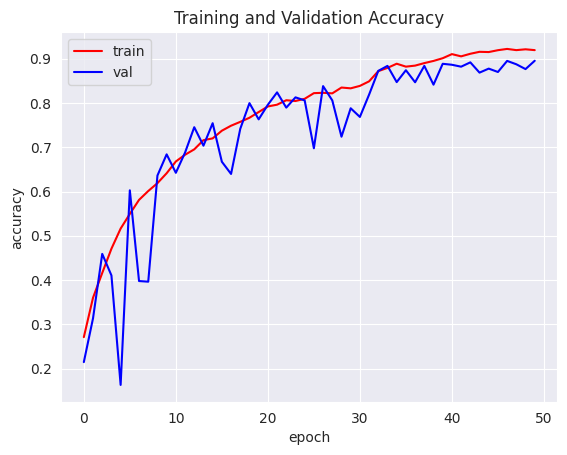

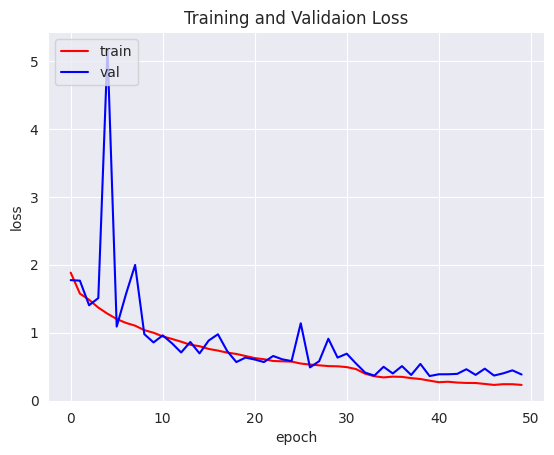

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
import pickle

with open('history_model_1.pkl', 'wb') as f:
    pickle.dump(history_1.history, f)

!cp -r history_model_1.pkl /content/drive/MyDrive/proyek_BPML-6/models/

In [ ]:
from tensorflow.keras.models import load_model

model_1_best = load_model("/content/drive/MyDrive/proyek_BPML-6/models/best_model_1.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


402/402 ━━━━━━━━━━━━━━━━━━━━ 95s 232ms/step - accuracy: 0.9307 - loss: 0.2044

Training Accuracy: 0.930
Training Loss: 0.205
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8887 - loss: 0.3641

📊 Validation Accuracy: 0.896
📉 Validation Loss: 0.386
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8923 - loss: 0.3847

✅ Test Accuracy: 0.893
❌ Test Loss: 0.383
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step

📑 Classification Report:
              precision    recall  f1-score   support

      anjing       0.86      0.86      0.86       465
        ayam       0.85      0.95      0.90       431
      kucing       0.90      0.88      0.89       496
   kupu-kupu       0.91      0.94      0.93       480
        sapi       0.93      0.89      0.91       448
       tupai       0.93      0.84      0.88       436

    accuracy                           0.89      2756
   macro avg       0.89      0.89      0.89      2756
weighted avg       0.89      0.89      0.89      2756



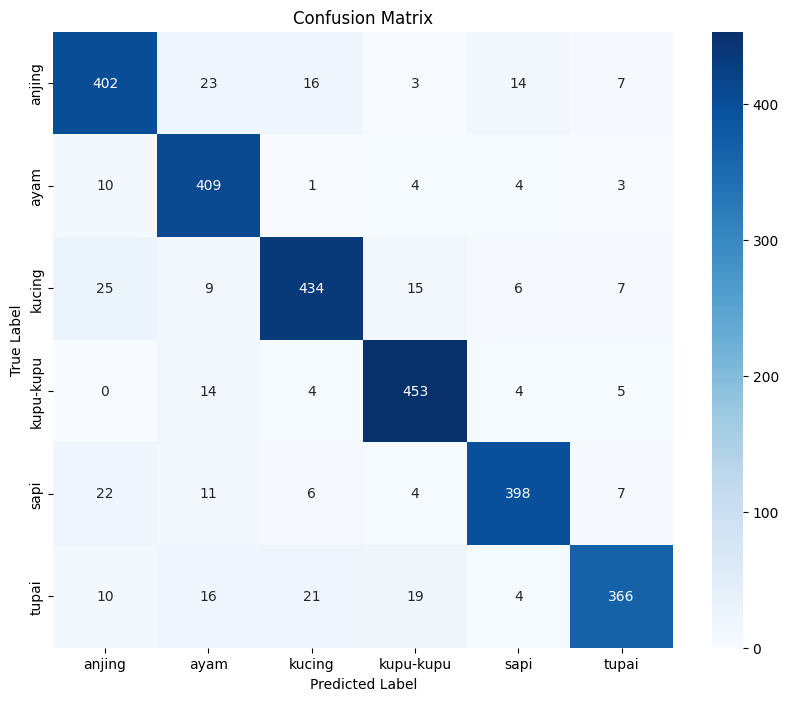

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Evaluasi pada training set ---
val_loss, val_acc = model_1_best.evaluate(train_generator)
print(f"\nTraining Accuracy: {val_acc:.3f}")
print(f"Training Loss: {val_loss:.3f}")

# --- Evaluasi pada validation set ---
val_loss, val_acc = model_1_best.evaluate(validation_generator)
print(f"\n📊 Validation Accuracy: {val_acc:.3f}")
print(f"📉 Validation Loss: {val_loss:.3f}")

# --- Evaluasi pada test set ---
test_loss, test_acc = model_1_best.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"❌ Test Loss: {test_loss:.3f}")

# --- Prediksi dan Laporan Klasifikasi ---
y_pred = model_1_best.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# --- Classification Report ---
print("\n📑 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Save model

In [ ]:
save_path = '/content/drive/MyDrive/proyek_BPML-6/models/model_1_best_saved'
tf.saved_model.save(model_1_best, save_path)

In [ ]:
import tensorflow as tf

saved_model_dir = '/content/drive/MyDrive/proyek_BPML-6/models/model_1_best_saved'
tflite_model_path = '/content/drive/MyDrive/proyek_BPML-6/models/model_1_best.tflite'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model TFLite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke .tflite dan disimpan di:", tflite_model_path)

✅ Model berhasil dikonversi ke .tflite dan disimpan di: /content/drive/MyDrive/proyek_BPML-6/models/model_1_best.tflite


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    /content/drive/MyDrive/proyek_BPML-6/models/model_1_best_saved \
    /content/drive/MyDrive/proyek_BPML-6/models/model_1_best_tfjs

2025-04-17 05:46:11.008508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744868771.084865   32492 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744868771.095906   32492 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-17 05:46:24.772042: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1744868784.772264   32492 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Model 2 (Transfer Learning)

### Image Data Generator

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Ganti dengan path dataset kamu
TRAIN_DIR = train_path
VAL_DIR = val_path
TEST_DIR = test_path

# Gunakan preprocessing bawaan MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 12857 images belonging to 6 classes.
Found 2756 images belonging to 6 classes.
Found 2756 images belonging to 6 classes.


### Pelatihan Model

In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
base_model.trainable = False

model_2 = Sequential()
model_2.add(base_model)

# Tambahan layer Conv2D setelah base model
model_2.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2)))

# Flatten dan FC layer
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(6, activation='softmax'))  # 6 kelas output

model_2.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,881,542 (14.81 MB)

 Trainable params: 1,623,302 (6.19 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

model_2_path = '/content/drive/MyDrive/proyek_BPML-6/models/best_model_2.keras'

# Custom Callback untuk stop saat akurasi tinggi
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
            print(f"\n✅ Target akurasi tercapai, menghentikan training di epoch {epoch+1}")
            self.model.stop_training = True

# Callback untuk mengurangi learning rate saat val_accuracy stagnan
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Callback lain
callbacks = myCallback()
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=model_2_path, save_best_only=True, monitor='val_accuracy', mode='max')

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_2 = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    batch_size=32,
    callbacks=[callbacks, reduce_lr, early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 199s 464ms/step - accuracy: 0.8224 - loss: 0.5994 - val_accuracy: 0.9612 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 170s 424ms/step - accuracy: 0.9158 - loss: 0.2667 - val_accuracy: 0.9557 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 201s 422ms/step - accuracy: 0.9247 - loss: 0.2426 - val_accuracy: 0.9739 - val_loss: 0.0896 - learning_rate: 0.0010
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 174s 432ms/step - accuracy: 0.9360 - loss: 0.2005 - val_accuracy: 0.9717 - val_loss: 0.0888 - learning_rate: 0.0010
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 172s 427ms/step - accuracy: 0.9357 - loss: 0.1953 - val_accuracy: 0.9670 - val_loss: 0.1066 - learning_rate: 0.0010
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 170s 423ms/step - accuracy: 0.9414 - loss: 0.1859 - val_accuracy: 0.9615 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 169s 420ms/step - accura

In [ ]:
import pickle

with open('history_model_2.pkl', 'wb') as f:
    pickle.dump(history_2.history, f)

!cp -r history_model_2.pkl /content/drive/MyDrive/proyek_BPML-6/models/

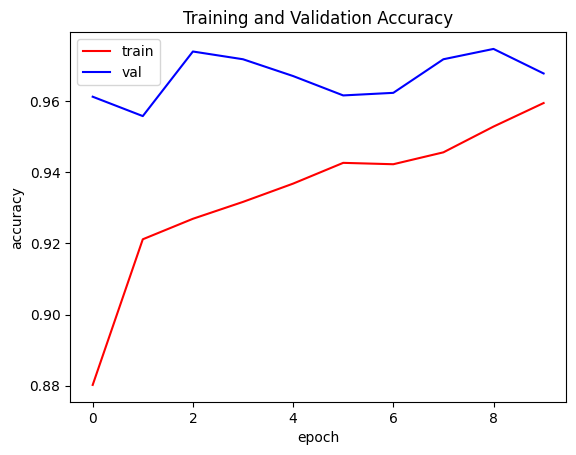

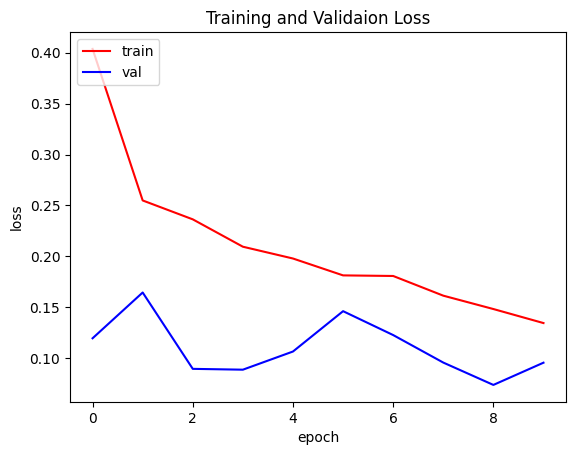

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model_2_best = load_model("/content/drive/MyDrive/proyek_BPML-6/models/best_model_2.keras")

402/402 ━━━━━━━━━━━━━━━━━━━━ 167s 402ms/step - accuracy: 0.9638 - loss: 0.1062

Training Accuracy: 0.967
Training Loss: 0.096
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.9712 - loss: 0.0727

📊 Validation Accuracy: 0.975
📉 Validation Loss: 0.074


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9700 - loss: 0.1053

✅ Test Accuracy: 0.976
❌ Test Loss: 0.093
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step

📑 Classification Report:
              precision    recall  f1-score   support

      anjing       0.97      0.96      0.96       465
        ayam       0.97      0.99      0.98       431
      kucing       0.97      0.97      0.97       496
   kupu-kupu       1.00      0.99      0.99       480
        sapi       0.98      0.97      0.97       448
       tupai       0.99      0.97      0.98       436

    accuracy                           0.98      2756
   macro avg       0.98      0.98      0.98      2756
weighted avg       0.98      0.98      0.98      2756



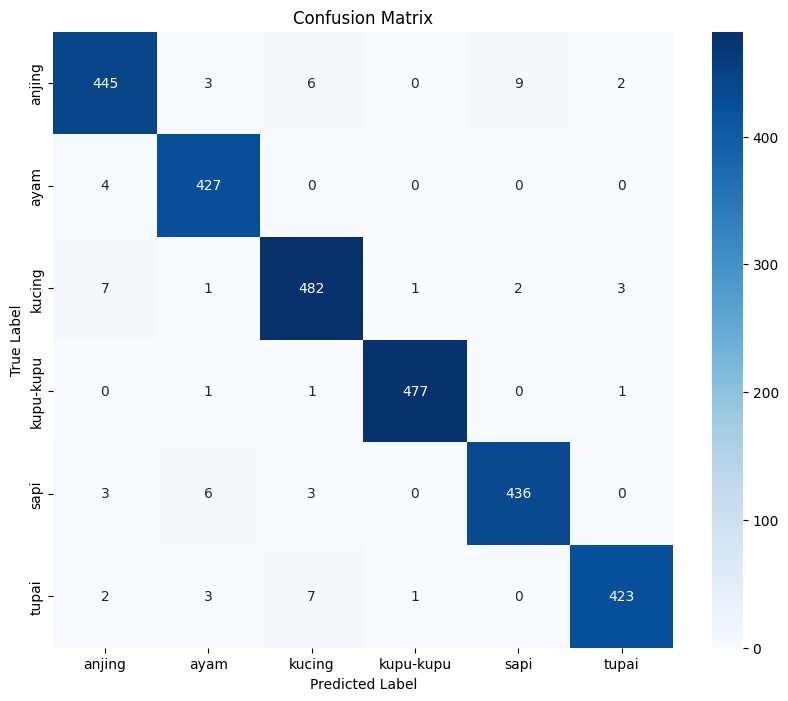

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Evaluasi pada training set ---
val_loss, val_acc = model_2_best.evaluate(train_generator)
print(f"\nTraining Accuracy: {val_acc:.3f}")
print(f"Training Loss: {val_loss:.3f}")

# --- Evaluasi pada validation set ---
val_loss, val_acc = model_2_best.evaluate(validation_generator)
print(f"\n📊 Validation Accuracy: {val_acc:.3f}")
print(f"📉 Validation Loss: {val_loss:.3f}")

# --- Evaluasi pada test set ---
test_loss, test_acc = model_2_best.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc:.3f}")
print(f"❌ Test Loss: {test_loss:.3f}")

# --- Prediksi dan Laporan Klasifikasi ---
y_pred = model_2_best.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# --- Classification Report ---
print("\n📑 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Save Model

In [ ]:
save_path = '/content/drive/MyDrive/proyek_BPML-6/models/model_2_best_saved'
tf.saved_model.save(model_2_best, save_path)

In [ ]:
import tensorflow as tf

saved_model_dir = '/content/drive/MyDrive/proyek_BPML-6/models/model_2_best_saved'
tflite_model_path = '/content/drive/MyDrive/proyek_BPML-6/models/model_2_best.tflite'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model TFLite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke .tflite dan disimpan di:", tflite_model_path)

✅ Model berhasil dikonversi ke .tflite dan disimpan di: /content/drive/MyDrive/proyek_BPML-6/models/model_2_best.tflite


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    /content/drive/MyDrive/proyek_BPML-6/models/model_2_best_saved \
    /content/drive/MyDrive/proyek_BPML-6/models/model_2_best_tfjs

2025-04-17 05:47:40.707209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744868860.726620   32921 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744868860.735110   32921 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-17 05:47:44.934787: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1744868864.934973   32921 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference

### Inference Model 1

In [ ]:
from tensorflow import keras

model_1_best = keras.models.load_model('/content/drive/MyDrive/proyek_BPML-6/models/model_1_best.keras')

Saving kucing.jpg to kucing (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
🧠 Prediksi: kucing (confidence: 1.00)


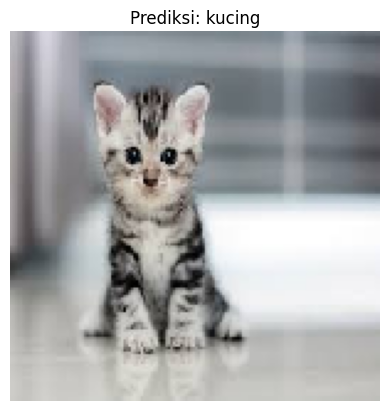

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img


uploaded = files.upload()  # User bisa pilih file gambar

for fn in uploaded.keys():
    img_path = fn

# Load dan proses gambar
img = load_img(img_path, target_size=(150, 150))  # Ukuran sesuai dengan input model_1
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
img_array = img_array / 255.0  # Normalisasi seperti saat training

# Prediksi
prediction = model_1_best.predict(img_array)

# Output kelas
predicted_class_index = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

# Ganti ini sesuai urutan label saat training
class_labels = list(train_generator.class_indices.keys())

print(f"🧠 Prediksi: {class_labels[predicted_class_index]} (confidence: {confidence:.2f})")

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_labels[predicted_class_index]}")
plt.show()

### Inference model 2

In [ ]:
from tensorflow import keras

model_2_best = keras.models.load_model('/content/drive/MyDrive/proyek_BPML-6/models/model_2_best.keras')

Saving ayam.jpg to ayam.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
🧠 Prediksi: ayam (confidence: 1.00)


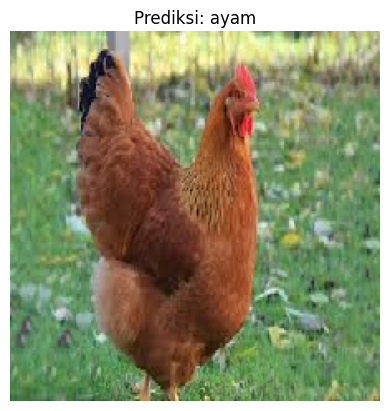

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img


uploaded = files.upload()  # User bisa pilih file gambar

for fn in uploaded.keys():
    img_path = fn

# Load dan proses gambar
img = load_img(img_path, target_size=(224, 224))  # Ukuran sesuai dengan input model_2
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
img_array = img_array / 255.0  # Normalisasi seperti saat training

# Prediksi
prediction = model_2_best.predict(img_array)

# Output kelas
predicted_class_index = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

# Ganti ini sesuai urutan label saat training
class_labels = list(train_generator.class_indices.keys())

print(f"🧠 Prediksi: {class_labels[predicted_class_index]} (confidence: {confidence:.2f})")

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_labels[predicted_class_index]}")
plt.show()

## Inference Menggunakan Web (tfjs model 2)

Link GitHub: https://github.com/abdul-rar/klasifikasi-gambar-hewan.git

**Screenshot Inference**

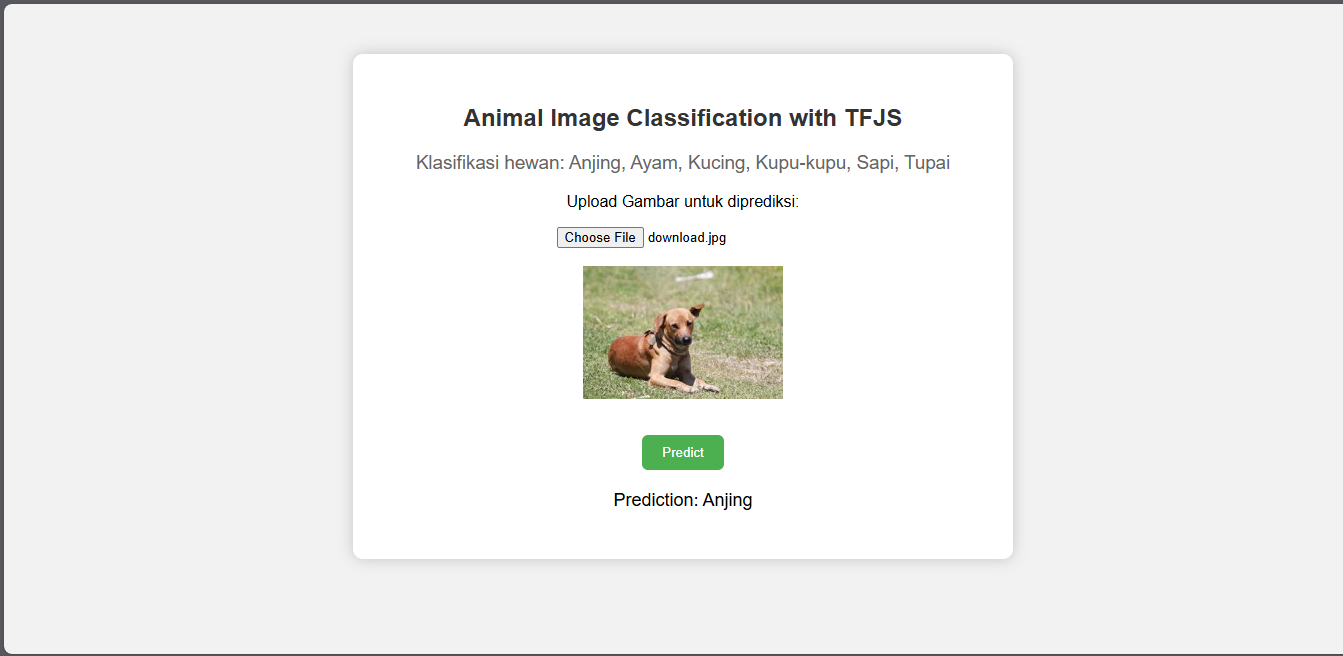

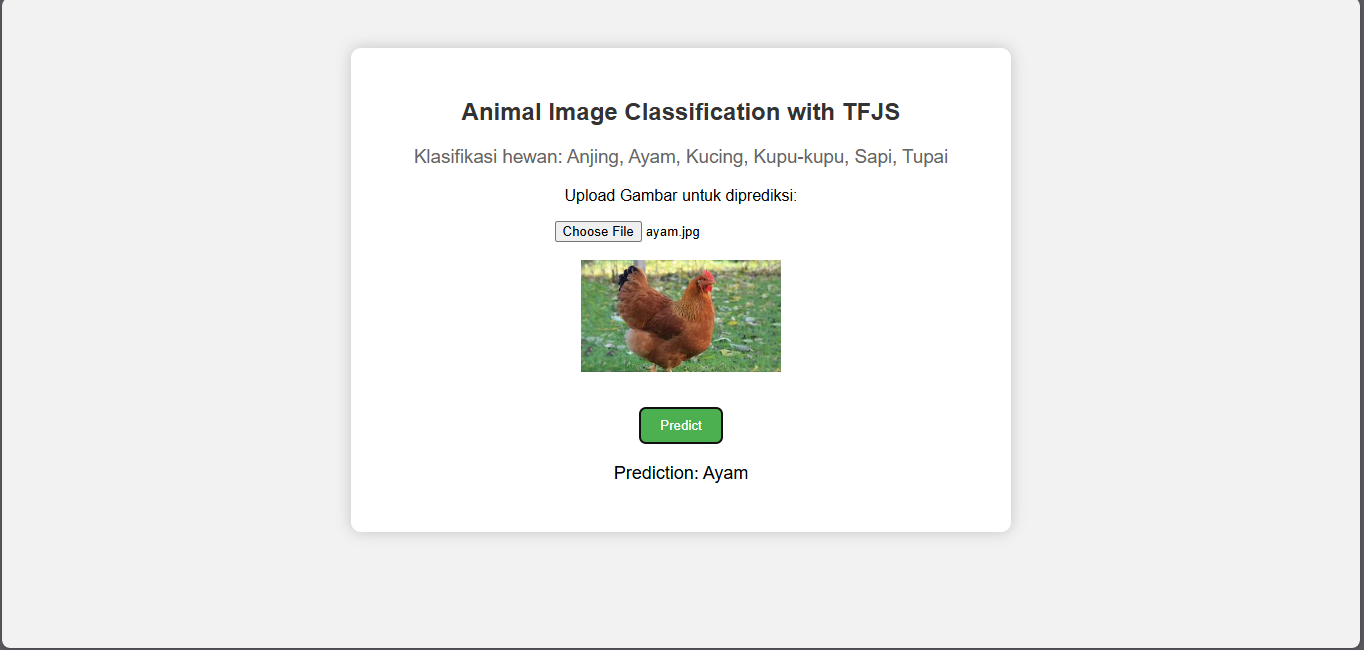

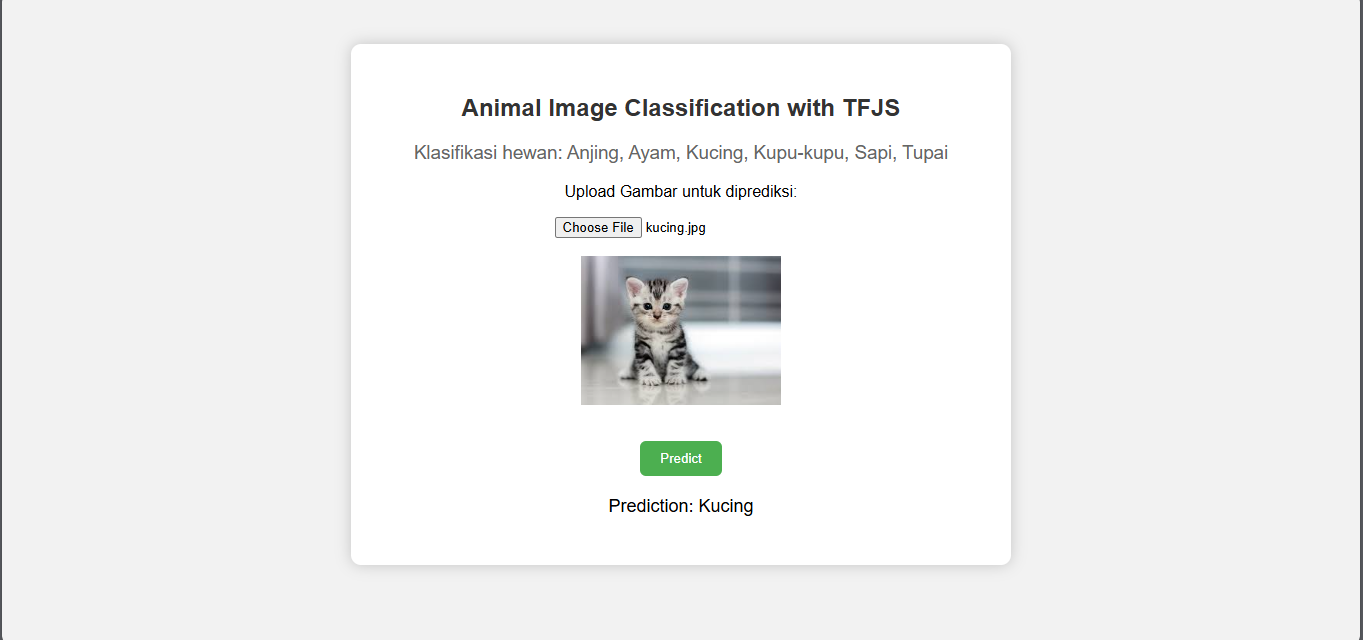

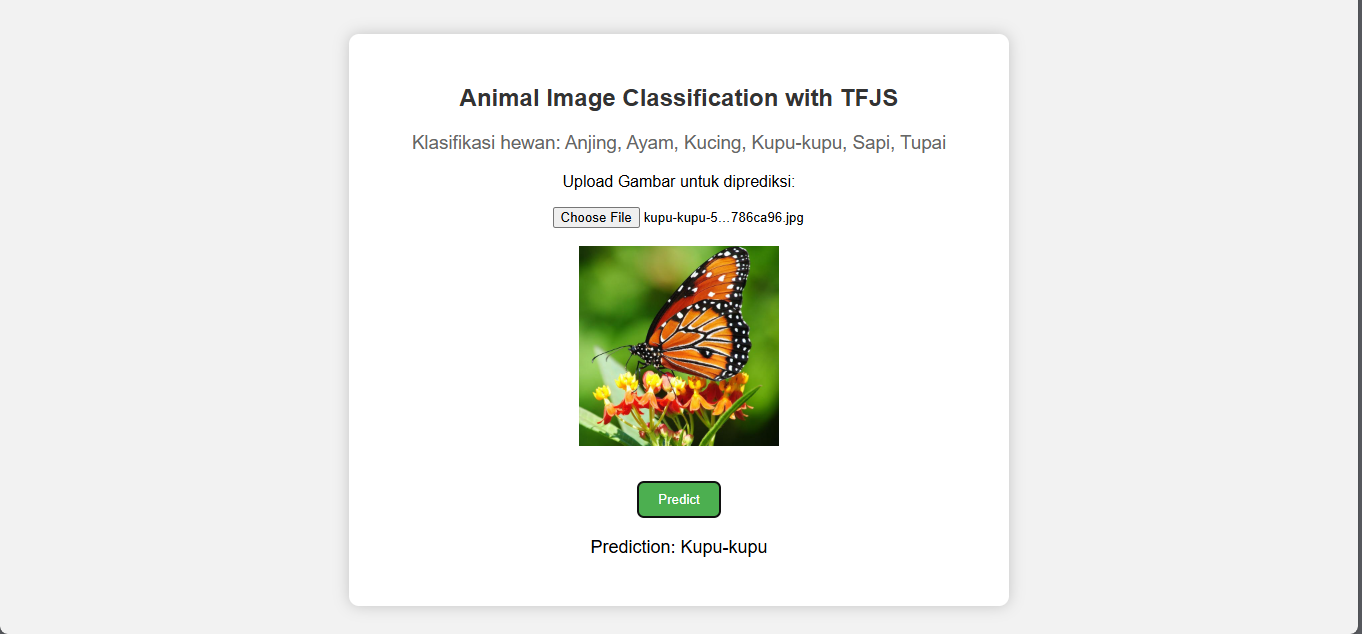

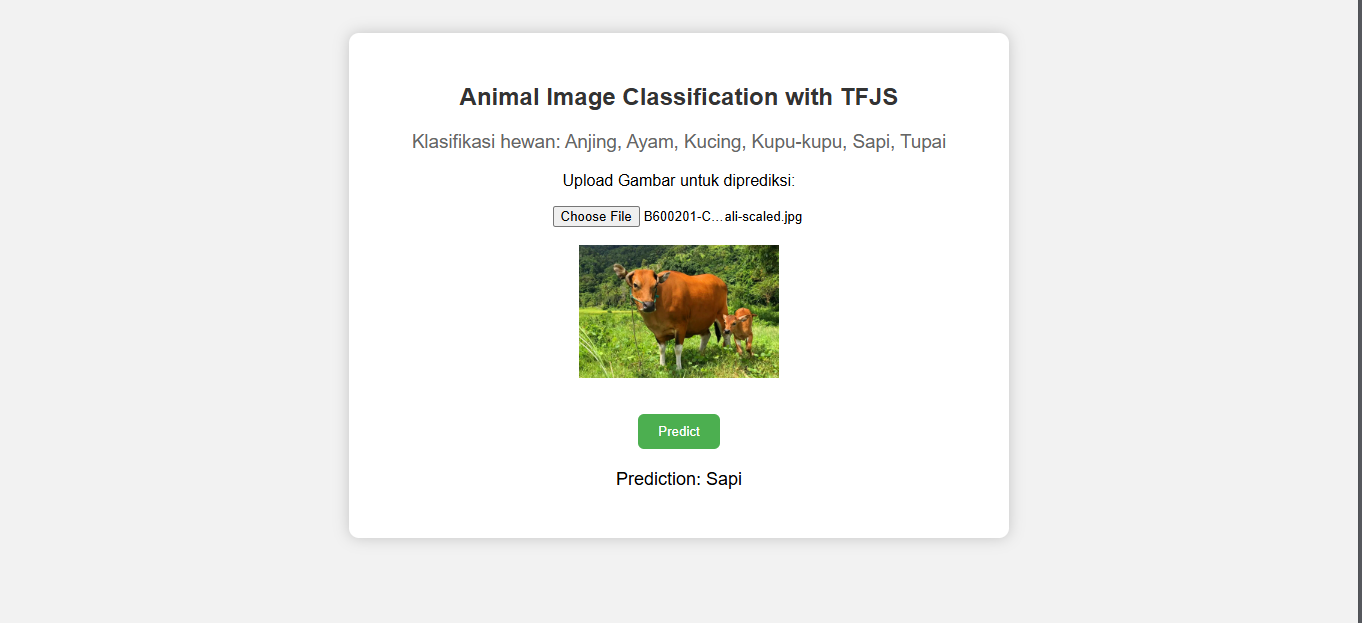

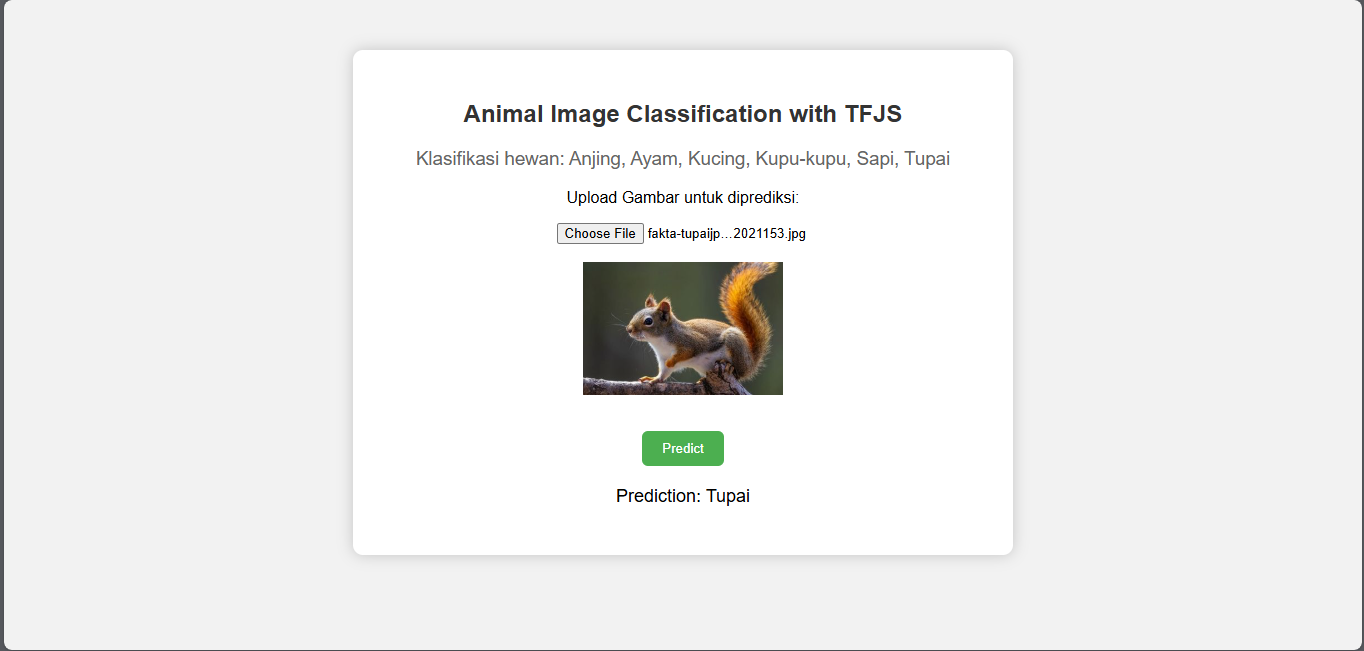